# inspect ichthyop simulations

Setup diagnostics:

- absolute dispersion: 
    - maps of probability
    - integrate as a function of distance (probability displacement<1km ...)
    - condition on tides
- relative dispersion
    - setup pdf
    - integrate as a function of distance (probability separation<1km ...)


Rerun with larger dataset (launch every 5 days)

Need fix: some particle dive



In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram

import taos.mars as ms
import taos.drifters as dr

In [2]:
from dask.distributed import Client, LocalCluster

if False:
    cluster = LocalCluster()
else:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=3)
#
client = Client(cluster)
client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: pars

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.216:8787/status,
Dashboard: http://10.148.0.216:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.216:47198,Workers: 0
Dashboard: http://10.148.0.216:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---

## simulation paths

In [ ]:
work_dir = "/home/datawork-lops-osi/aponte/taos/ichthy"

# zarr archive that will concatenate relevant data
zarr = os.path.join(work_dir, "drifters_combined.zarr")

# reference latitude
lat_start0 = 49.5

In [ ]:
# load 1 arbitrary snapshot for bathy
ds = ms.load_date("2011-01-01 00:00:00")

---

## one lagrangian simulation

In [23]:
#run = "t_201309"
#run = "t_201601"
run = "2011-08-10_lat{:.2f}".format(lat_start0)

run_dir = os.path.join(work_dir, run)

dsr = dr.load_run(run_dir)
#dsr

**Some drifter dive !!**

Needs to be fixed

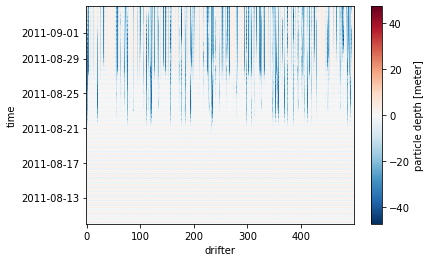

In [24]:
dsr.depth.plot()

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

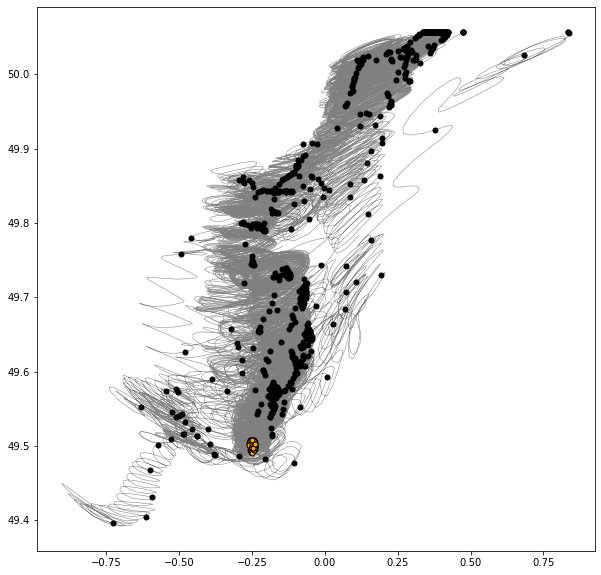

In [25]:
dr.plot_trajectories(dsr, dt=2)

(None,
 <GeoAxesSubplot:title={'center':'water depth [m]'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

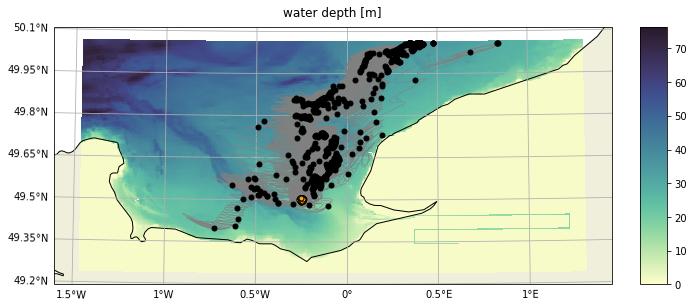

In [26]:
fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
           title="water depth [m]",
           vmin=0,
           cmap=ms.cm.deep,
           zoom=0, figsize=0,
          )

dr.plot_trajectories(dsr, ax=fac["ax"], dt=2)

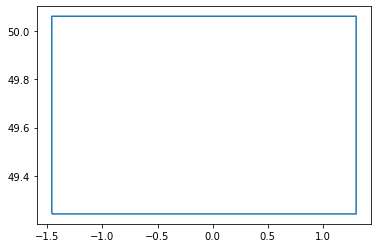

In [27]:
plt.plot(dsr.region_edge.squeeze()[:,1], dsr.region_edge.squeeze()[:,0])

---

## load multiple runs

- combine into a single xarray dataset
- compute local coordinates
- store

In [9]:
def load_run(r, template=None, verbose=False):
    """ Load a single run, massage dataset such as to 
    """
    # "/home/datawork-lops-osi/aponte/taos/ichthy/2011-02-01_lat49.32"
    _date = pd.Timestamp(r.split("/")[-1].split("_")[0])
    _lat = float(r
                 .split("/")[-1]
                 .split("_")[1]
                 .replace("lat","")
               )
    ds = dr.load_run_simple(r)
    
    if ds is None:
        # not output file, use template if provided
        if verbose:
            print("{}: no netcdf file found".format(r))
        if template is not None:
            ds = template.assign_coords(date_start=[_date], lat_start=[_lat])
            ds = ds.assign(done=~ds.done)
            ds["lon"] = xr.full_like(ds["lon"], np.NaN)
            ds["lat"] = xr.full_like(ds["lat"], np.NaN)
            return ds
        else:
            return
    #
    ds = dr.normalize_time(ds)
    ds = ds.expand_dims(date_start=[_date],
                        lat_start=[_lat]
                       )
    ds["region_edge"] = ds["region_edge"].squeeze()
    ds["done"] = (("date_start", "lat_start"), [[ds.attrs["done"]]])
    #del ds["region_edge"]
    ds = ds.chunk(dict(lat_start=1))
    
    return ds


In [12]:
#runs = sorted(glob(os.path.join(work_dir, "t_*")))
#runs = sorted(glob(os.path.join(work_dir, "*_lat49.42")))

#ds_runs = [dr.load_run(r) for r in runs]
#ds_runs = [norm_time(d) for d in ds_runs if d is not None]
#dsr = xr.concat(ds_runs, dim="run")

In [10]:
#runs = sorted(glob(os.path.join(work_dir, "2011-02*_lat49.3*")))
#runs = sorted(glob(os.path.join(work_dir, "2011-02*_lat*")))
runs = sorted(glob(os.path.join(work_dir, "2011-*_lat*")))
runs = [r for r in runs if ".pbs" not in r]

# extract start dates and location
date_start = set([r.split("/")[-1].split("_")[0] for r in runs])
lat_start = set([float(r.split("/")[-1]
                       .split("_")[1]
                       .replace("lat","")
                      ) for r in runs])
date_start = sorted(list(date_start)) # iteration over set is not sorted
lat_start = sorted(list(lat_start))

# load 1 drifter simulation, will be used as a template dataset
ds1 = load_run(runs[0])
#ds1

In [11]:
get_run_path = lambda date, lat: os.path.join(work_dir, date+"_lat{:.2f}".format(lat))

_dsr = [[load_run(get_run_path(date, lat), template=ds1, verbose=False) 
         for date in date_start]
        for lat in lat_start]

#dsr = xr.merge([ds for ds in _dsr if ds is not None]) # crashes the kernel
dsr = (xr.combine_nested(_dsr, 
                         concat_dim=["lat_start", "date_start"], 
                         combine_attrs="override",
                        )
       .persist()
      )

# !!! should do with xarray.open_mfdataset !!!

# .nc.part files are not converted totally

# 2011-12-22_lat49.42
# (equinox) taos/ichthy% grep 2011-12-22_lat49.42 icl*
# icl162.o7788552:ichthyop[info] Opened configuration file /home/datawork-lops-osi/aponte/taos/ichthy/2011-12-22_lat49.42/cfg.xml
# icl162.o7788552:ichthyop[info] Created output file /home/datawork-lops-osi/aponte/taos/ichthy/2011-12-22_lat49.42/output/taos__ichthyop-run202111092302.nc.part
#ichthyop[info] Step 2868 / 7200
# ichthyop[severe] An error occured while running the simulation | java.io.IOException: [Dataset] Unable to find any file following /home/ref-oc-public/modeles_marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2011/MARC_F1-MARS3D-SEINE_20111231T2300Z.nc

# ichthyop[severe] An error occured while running the simulation | java.io.IOException: [Dataset] Unable to find any file following /home/ref-oc-public/modeles_marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2011/MARC_F1-MARS3D-SEINE_20111231T2300Z.nc

In [14]:
# transform lon, lat in local x/y

#lon_ref = abs(float(dsr.attrs["release.stain.lon_stain"]))
#lat_ref = abs(float(dsr.attrs["release.stain.lat_stain"]))
lon_ref = -0.25
lat_ref = 49.3

dla = 111e3
dlo = float(dla*np.cos(np.pi/180*lat_ref))

dsr["x"] = (dsr.lon - lon_ref)*dlo
dsr["y"] = (dsr.lat - lat_ref)*dla

dsr["dx_absolute"] = dsr.x - dsr.x.isel(time=0)
dsr["dy_absolute"] = dsr.y - dsr.y.isel(time=0)

dsr["x_center"] = dsr["x"].mean("drifter")
dsr["y_center"] = dsr["y"].mean("drifter")

dsr["dx_relative"] = dsr["x"] - dsr["x_center"]
dsr["dy_relative"] = dsr["y"] - dsr["y_center"]

dsr["dl_absolute"] = np.sqrt(dsr["dx_absolute"]**2 + dsr["dy_absolute"]**2)
dsr["dl_relative"] = np.sqrt(dsr["dx_relative"]**2 + dsr["dy_relative"]**2)

dsr = dsr.persist()

In [20]:
# rechunk and store
dsr = dsr.chunk(dict(date_start=50))
dsr.to_zarr(zarr, mode="w")

---

## inspect combined result: focus on a single location

In [51]:
# reload data
dsr = xr.open_zarr(zarr).persist()

In [131]:
def bin_geographically(ds, 
                       dl=2e3,
                       dims=["date_start", "drifter"], 
                       persist=True,
                      ):
    """ Bin locations geographically
    
    Parameters
    ----------
    ds: xr.Dataset
        contains lon, lat
    dl: float
        bin size in meters
    dims: list of str
        Dimensions to bin over
    persist: boolean
        Flag in order to bin data
    """
    
    edges = ds.region_edge.isel(date_start=0, lat_start=0)
    _lat = edges[:,0]
    _lon = edges[:,1]
        
    dla = 111e3
    dlo = float(dla*np.cos(np.pi/180*_lat.mean()))

    lon_bins = np.arange(_lon.min()-dl/dlo, _lon.max()+dl/dlo, dl/dlo)
    lat_bins = np.arange(_lat.min()-dl/dla, _lat.max()+dl/dla, dl/dla)

    h = histogram(dsr.lon, dsr.lat, bins=[lon_bins, lat_bins], 
                  dim=dims)
    
    if persist:
        h = h.persist()
        
    return h

def bin_displacements(dx, dy, 
                     dl_step=500, 
                     dl_max=20e3,
                     dims=["date_start", "drifter"], 
                     persist=True,
                    ):
    """ Bin displacements in two direction
    
    Parameters
    ----------
    dx, dy: xr.Dataarray
        horizontal displacements
    dl_step: float
        bin size in meters
    dl_max: float
        max displacement considered
    dims: list of str
        dimensions to bin over
    persist: boolean
        flag to persist data
    """
    x_bins = np.arange(-dl_max, dl_max, dl_step)
    y_bins = np.arange(-dl_max, dl_max, dl_step)

    h = (histogram(dx, dy, bins=[x_bins, y_bins],
                   dim=dims,
                   density=True,                   
                  )
        )    
    
    if persist:
        h = h.persist()
        
    return h


def bin_displacement(dl,
                     dl_step=500, 
                     dl_max=20e3,
                     dims=["date_start", "drifter"], 
                     persist=True,
                    ):
    """ Bin displacement (distance)
    
    Parameters
    ----------
    dx, dy: xr.Dataarray
        horizontal displacements
    dl_step: float
        bin size in meters
    dl_max: float
        max displacement considered
    dims: list of str
        dimensions to bin over
    persist: boolean
        flag to persist data
    """
    dl_bins = np.arange(0., dl_max, dl_step)

    h = (histogram(dl, bins=[dl_bins,], 
               dim=dims,
               density=True,
              )
         .rename("density")
        )
    ds = h.to_dataset()

    dim = dl.name+"_bin"
    ds["mean"] = (h*h[dim]).integrate(dim)
    ds["cum"] = h.cumulative_integrate(dim)
    # bad form: ensures cum finishes at 1:
    ds["cum"] = ds["cum"]/ds["cum"].isel(**{dim: -1})
    
    if persist:
        ds = ds.persist()
        
    return ds

### Absolute dispersion

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

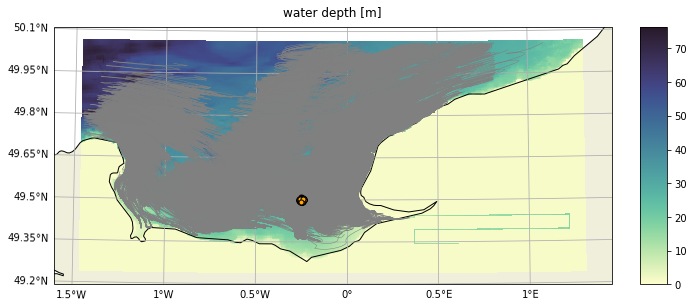

In [39]:
# not great
fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
           title="water depth [m]",
           vmin=0,
           cmap=ms.cm.deep,
           zoom=0, figsize=0,
          )

_ds = dsr.sel(lat_start=lat_start0, method="nearest")
for _d in _ds.date_start[::10]:
    dr.plot_trajectories(_ds.sel(date_start=_d), ax=fac["ax"])

In [44]:
h = bin_geographically(dsr)

In [51]:
#np.log10(h.isel(time=range(0,24*20,24))).plot(x="lon_bin", y="lat_bin", col="time", col_wrap=3)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

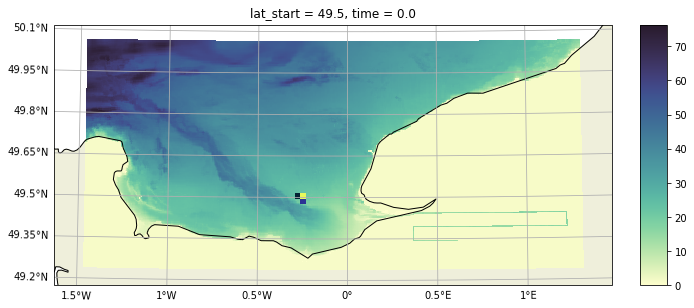

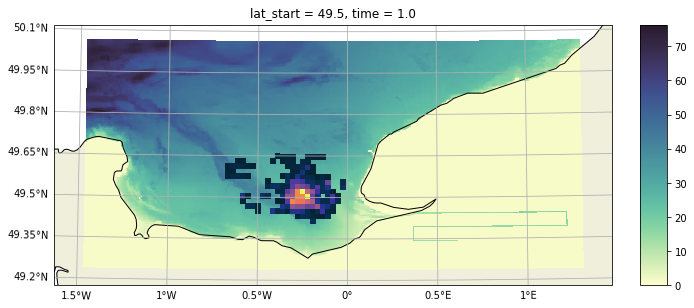

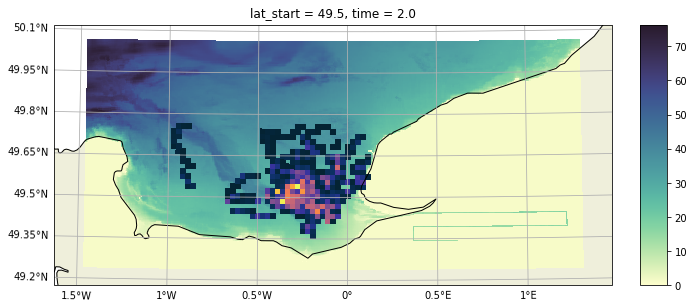

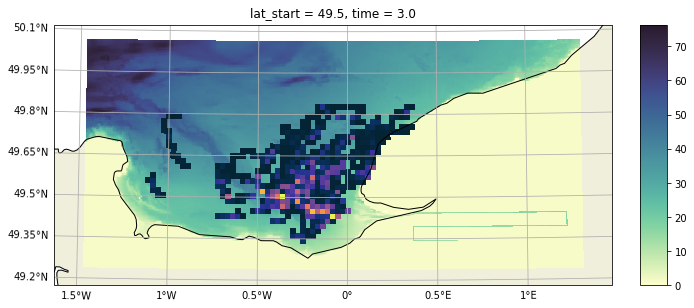

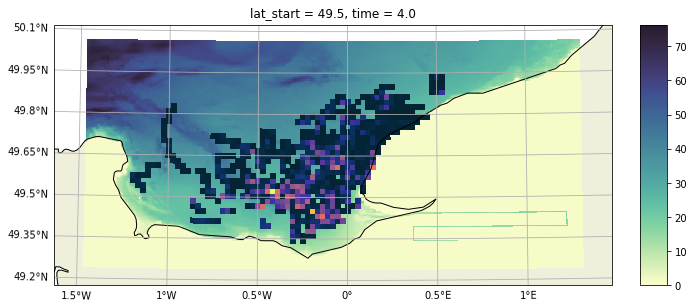

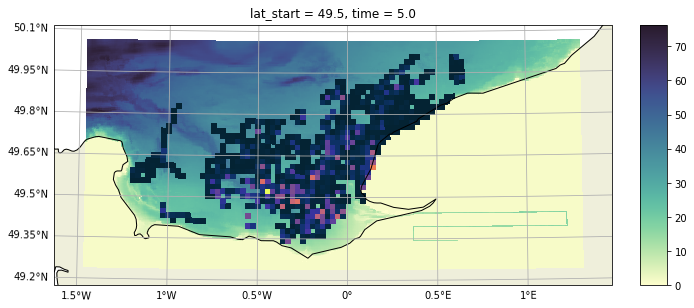

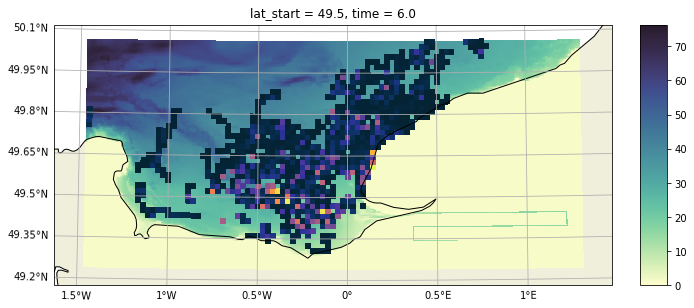

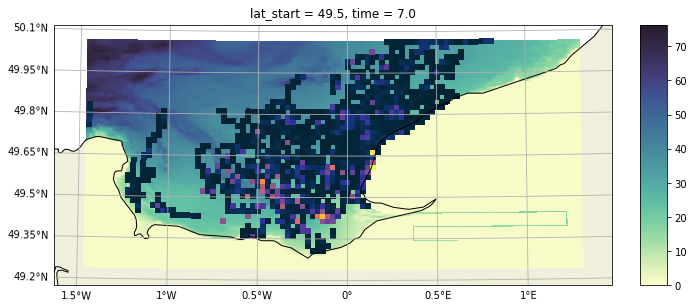

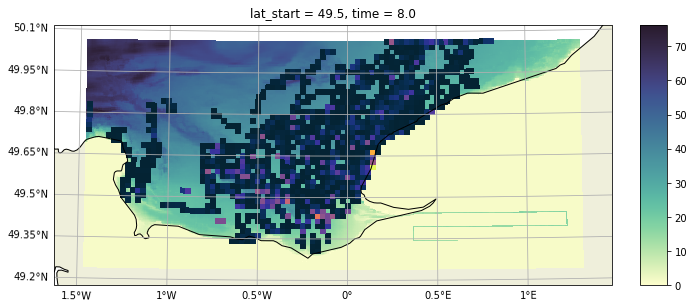

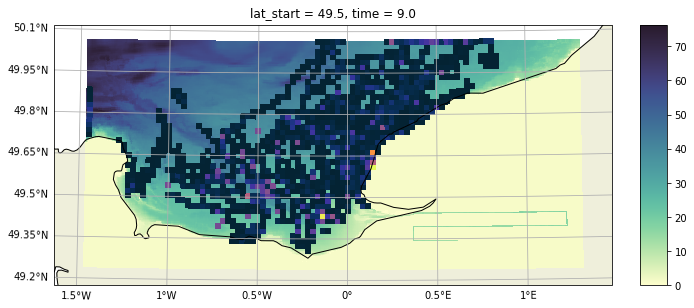

In [48]:
_h = h.sel(lat_start=lat_start0, method="nearest")

for t in range(0,24*10,24):

    fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
               title="water depth [m]",
               vmin=0,
               cmap=ms.cm.deep,
               zoom=0, figsize=0,
              )
    toplt = _h.isel(time=t)
    toplt = toplt.where(toplt>0) # mask 0s
    #toplt = np.log10(toplt)
    (toplt
     .plot
     .pcolormesh(ax=fac["ax"], 
                 x="lon_bin", y="lat_bin",
                 cmap=ms.cm.thermal,
                 add_colorbar=False,
                 transform=dr.ccrs.PlateCarree(),
                )
    )

### in meters

In [132]:
h = bin_displacements(dsr.dx_absolute, dsr.dy_absolute, dl_max=40e3)

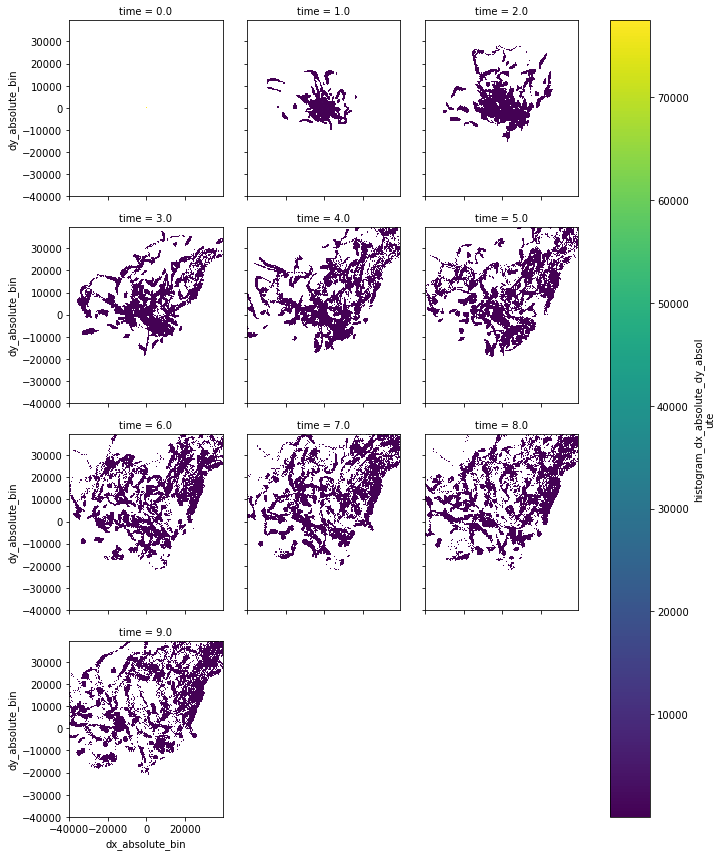

In [66]:
_h = h.sel(lat_start=lat_start0, method="nearest")

toplt = _h.isel(time=range(0,24*10,24))
toplt = toplt.where(toplt>0)
#toplt = np.log10(toplt)
toplt.plot(x="dx_absolute_bin", y="dy_absolute_bin", col="time", col_wrap=3)

In [133]:
ds_abs = bin_displacement(dsr.dl_absolute, dl_max=40e3)

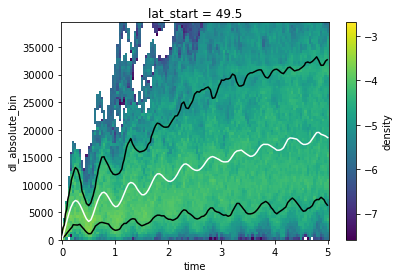

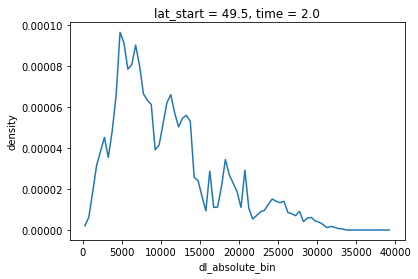

In [134]:
_ds = ds_abs.sel(lat_start=lat_start0, method="nearest")
_ds = _ds.sel(time=slice(0, 5))

_h = _ds["density"]

#toplt = _h.isel(time=range(0,24*10,24))
toplt = _h
#toplt = toplt.where(toplt>0)
toplt = np.log10(toplt)

fig, ax = plt.subplots(1,1)
toplt.plot(ax=ax, x="time", y="dl_absolute_bin")
_ds["cum"].plot.contour(levels=[0.1, 0.9], colors="k", x="time", y="dl_absolute_bin")
ax.plot(_h.time, _ds["mean"], color="w")

fig, ax = plt.subplots(1,1)
_h.sel(time=2, method="nearest").plot(ax=ax)

### Relative dispersion

In [116]:
h = bin_displacements(dsr.dx_relative, dsr.dy_relative, dl_max=40e3)

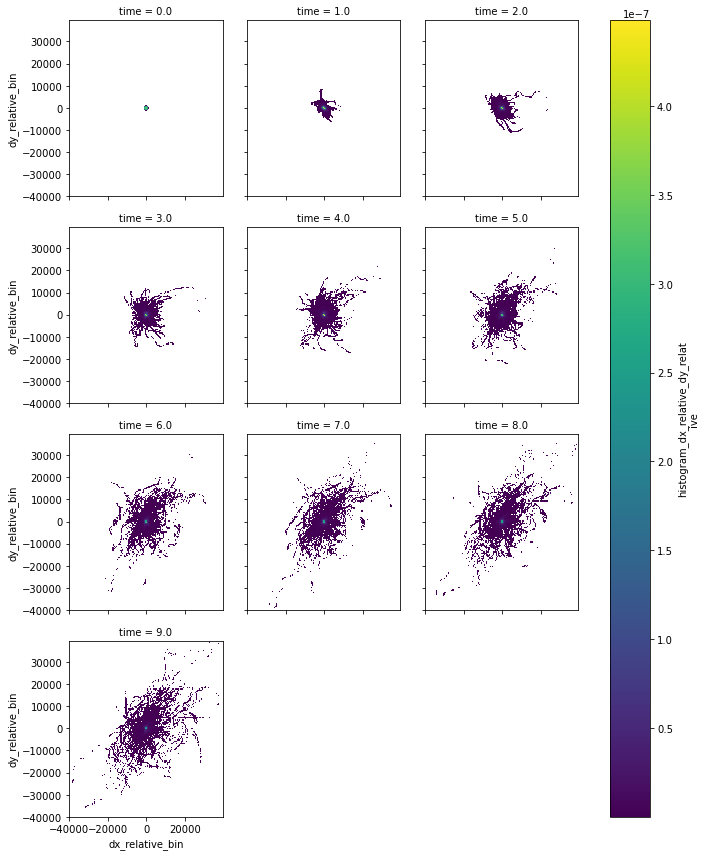

In [117]:
_h = h.sel(lat_start=lat_start0, method="nearest")

toplt = _h.isel(time=range(0,24*10,24))
toplt = toplt.where(toplt>0)
#toplt = np.log10(toplt)

toplt.plot(x="dx_relative_bin", y="dy_relative_bin", col="time", col_wrap=3)

In [135]:
ds_rel = bin_displacement(dsr.dl_relative, dl_max=20e3)

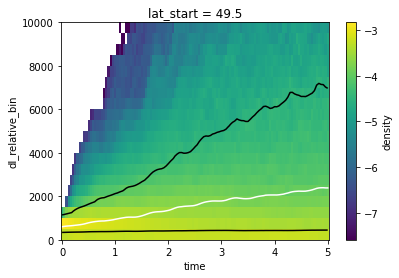

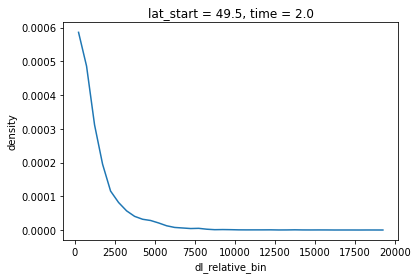

In [140]:
_ds = ds_rel.sel(lat_start=lat_start0, method="nearest")
_ds = _ds.sel(time=slice(0, 5))

_h = _ds["density"]

toplt = _h
#toplt = toplt.where(toplt>0)
toplt = np.log10(toplt)

fig, ax = plt.subplots(1,1)

toplt.plot(ax=ax, x="time", y="dl_relative_bin")
_ds["cum"].plot.contour(levels=[0.1, 0.9], colors="k", x="time", y="dl_relative_bin")
ax.plot(_h.time, _ds["mean"], color="w")
ax.set_ylim(0,10e3)

fig, ax = plt.subplots(1,1)
_h.sel(time=2, method="nearest").plot(ax=ax)


In [49]:
#compute fraction of drifters that have reached the bdy
#compute fraction of drifters that have beached

dsr["exited"] = xr.full_like(dsr.mortality, 1.).where(dsr.mortality==2, other=0)
dsr["beached"] = xr.full_like(dsr.mortality, 1.).where(dsr.mortality==4, other=0)

dsr = dsr.persist()

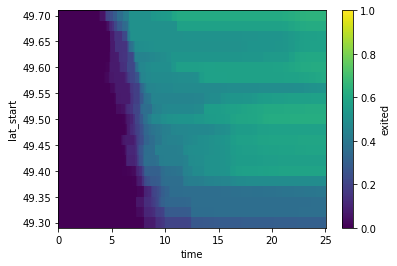

In [70]:
_ds = dsr["exited"].mean(["date_start", "drifter"])
_ds.plot(vmax=1.)

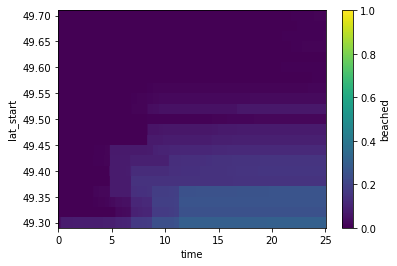

In [71]:
_ds = dsr["beached"].mean(["date_start", "drifter"])
_ds.plot(vmax=1.)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

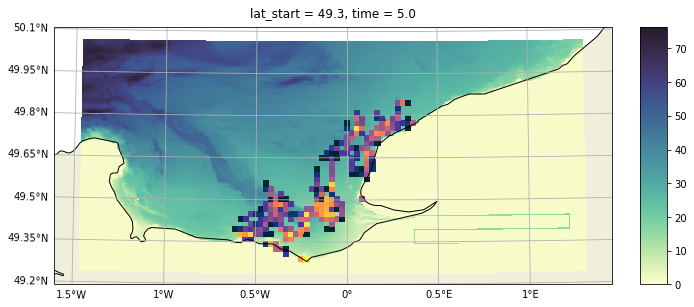

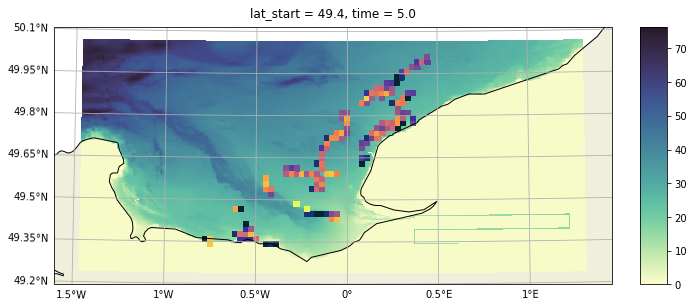

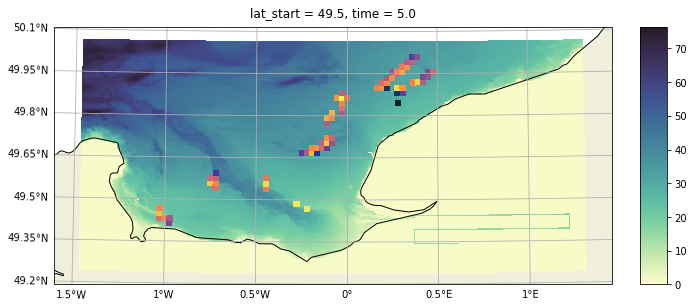

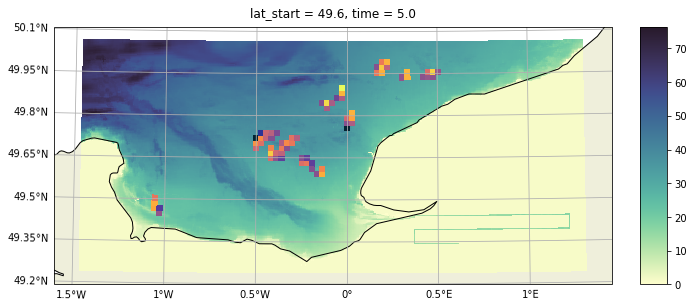

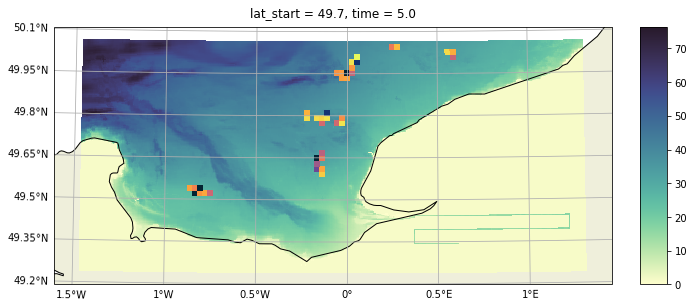

In [49]:
_h = h.sel(time=5., method="nearest")

for lat in range(0, _h.lat_start.size, 5):

    fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
               title="water depth [m]",
               vmin=0,
               cmap=ms.cm.deep,
               zoom=0, figsize=0,
              )
        
    (np.log10(_h.isel(lat_start=lat))
     .plot
     .pcolormesh(ax=fac["ax"], 
                 x="lon_bin", y="lat_bin",
                 cmap=ms.cm.thermal,
                 add_colorbar=False,
                 transform=dr.ccrs.PlateCarree(),
                )
    )

Bin absolute displacement

In [41]:
dl = dsr["dl_absolute"].mean(["drifter", "date_start"]).persist()

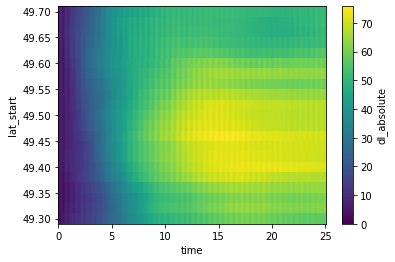

In [44]:
(dl/1e3).plot()

---
## relative dispersion

---

In [ ]:
cluster.close()